# モデルの評価とチューニング
前節では分類問題に対して色々な手法があることをみた。
また同じ手法でもハイパーパラメータを変えることで結果が変わることをみた。

今回はそれらの様々な結果を比較、評価する方法について見ていこう。

## 手書き文字データ
    
ここではsklearnにあらかじめ入っている手書き文字データの分類をしながら実際の分析の流れを見てみる。
以下のようにして、データをimportできる。  
データ数は1797で0から9までの10クラスある。
各データは8\*8行列に白黒の濃度を数値として変数にもつ。

In [1]:
%matplotlib inline
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np

digits = datasets.load_digits()
x,y = digits.images, digits.target
print(x.shape)
print(y.shape)
print({i:len(y[y==i]) for i in range(10)})
print(digits.images.shape, digits.data.shape)

(1797, 8, 8)
(1797,)
{0: 178, 1: 182, 2: 177, 3: 183, 4: 181, 5: 182, 6: 181, 7: 179, 8: 174, 9: 180}
(1797, 8, 8) (1797, 64)


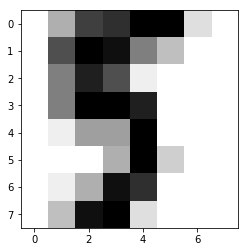

In [2]:
plt.imshow(x[15],cmap=plt.cm.gray_r)
plt.show()

In [3]:
x[15], y[15]

(array([[  0.,   5.,  12.,  13.,  16.,  16.,   2.,   0.],
        [  0.,  11.,  16.,  15.,   8.,   4.,   0.,   0.],
        [  0.,   8.,  14.,  11.,   1.,   0.,   0.,   0.],
        [  0.,   8.,  16.,  16.,  14.,   0.,   0.,   0.],
        [  0.,   1.,   6.,   6.,  16.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   5.,  16.,   3.,   0.,   0.],
        [  0.,   1.,   5.,  15.,  13.,   0.,   0.,   0.],
        [  0.,   4.,  15.,  16.,   2.,   0.,   0.,   0.]]), 5)

In [4]:
# データを一次元の配列に並び替える。
x = x.reshape((x.shape[0],-1))

## 訓練データと試験データ
機械学習手法の性能を調べるとき、手元にあるデータを訓練データと試験データに分割する。  
訓練データを使って学習させ、試験データを使って学習手法の性能評価を行う。  
また手法によっては各変数を標準化することが必要になる。  
これらはsklearnにそれぞれ用意されているメソッドを用いることにする。

In [5]:
# 訓練データと試験データに分割する
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

# データの標準化
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(x_train)# X_trainを使って標準化することに注意
x_train_std = sc.transform(x_train)
x_test_std = sc.transform(x_test)

上で用意したデータをパーセプトロンにより分類してみる。
fitにはtrainデータ、predictにはtestデータをそれぞれ用いていることに注意。

In [6]:
#パーセプトロンによる手書き文字の分類
from sklearn.linear_model import Perceptron
clf = Perceptron(n_iter=10, eta0=0.01, shuffle=True)
clf.fit(x_train_std, y_train)

#正解率を表示する
y_pred = clf.predict(x_test_std)
print('誤分類サンプル数: %d' % (y_test != y_pred).sum())
from sklearn.metrics import accuracy_score
print('正解率: %.2f' % accuracy_score(y_test, y_pred))

誤分類サンプル数: 53
正解率: 0.90


## 練習問題

前回扱った他の手法についても、上と同様にtestデータでの正解率を計算させてみよう。
またハイパーパラメータを変えることで正解率が変化するかどうかを観察してみよう。

In [7]:
# 学習の流れを関数にしておく
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

def classification(clf,x,y,name):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
    
    sc = StandardScaler()
    sc.fit(x_train)
    x_train_std = sc.transform(x_train)
    x_test_std = sc.transform(x_test)
    
    clf.fit(x_train_std,y_train)
    y_pred=clf.predict(x_test_std)
    print('%s: 誤分類サンプル数: %d' % (name, (y_test != y_pred).sum()))
    print('%s: 正解率: %.2f' % (name, accuracy_score(y_test, y_pred)))

#決定木
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion='entropy', max_depth=3)
classification(clf, x, y, '決定木')

決定木: 誤分類サンプル数: 247
決定木: 正解率: 0.54


## 評価指標について
正答率(accuracy)以外にどのような指標があるか見ていく。
- 混同行列(confusion matrix)
- 適合率(precision)
- 再現率(recall)
- F1-score

In [8]:
# SVMで分類
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

from sklearn.svm import SVC
clf = SVC(kernel='linear',C=1.0)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

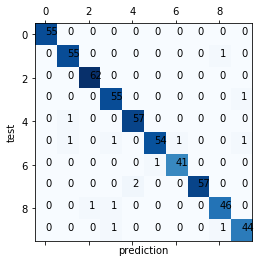

In [9]:
# 結果をconfusion matrixで表示
from sklearn.metrics import confusion_matrix
confmat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
ax.matshow(confmat,cmap=plt.cm.Blues)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,y=i,s=confmat[i,j])
plt.xlabel('prediction')
plt.ylabel('test')

クラス毎にサンプル数が偏る場合、正解率はあまりよい指標とは言えない。
例えば100人に1人しかかからない病気を判定したい時、何も考えずに全員健康といえば99%正解できる。

そこで、適合率precisionや再現率recall及びF1-scoreを用いる。

- pre=tp/(tp+fp)
- rec=tp/p=tp/(tp+fn)
- f1=2(pre * rec)/(pre+rec)

F1-scoreはpredictionとrecallの調和平均である。

例えば大量の画像から犬の画像か否かを判定する問題を考えよう。
- 適合率は犬と答えた画像のうち本当に犬の画像である割合。犬の画像を見落としたかどうかは気にしない。
- 再現率は全体の犬の画像のうちどれだけを犬の画像と判定したかの割合。間違えて犬と判定した数は気にしない。

つまり適合率が高く再現率が低いのは、慎重に犬の画像を選ぶ。
再現率が高く適合率が低いのは、迷ったら全部犬と答える。

## 交差検証法によるモデルの性能評価

予測関数のパラメータを学習したのち、
それを試験するためには別のデータを使わねばならない。
過学習を防ぐためである。

単に訓練データと試験データを分けるだけでは偶然性を排除できない。
より確率に左右されない評価をするために交差検証cross-validation, CVを行う。

訓練データをk個に分割する。
そのグループをX1からXkとする。
まずX1からX(k-1)を使って学習しXkで評価する。
次にX1からX(k-2)とXkを使って学習しX(k-1)で評価する。
これをk回繰り返すことでk種類の学習結果が得られる。

特に一つのサンプルをのぞいて学習させる場合をLOOという。

In [10]:
digits = datasets.load_digits()
x,y = digits.images, digits.target
x = x.reshape((x.shape[0],-1))

from sklearn.model_selection import cross_val_score
clf = SVC(kernel='linear',C=1)
scores = cross_val_score(clf, x, y, scoring='accuracy', cv=10)
print(scores)
print('Accuracy: %0.2f(+/- %0.2f)' % (scores.mean(), scores.std() *2))

[ 0.93513514  0.99453552  0.9281768   0.96111111  0.96089385  0.98882682
  0.96648045  0.97752809  0.93220339  0.96590909]
Accuracy: 0.96(+/- 0.04)


評価指標のデフォルトは正解率。
scoringを指定すれば他の指標も使える。

クラスの比率が均等でない場合、層化交差検証が良い。
トレーニングデータを分割する際にクラスごとに分割する。

グループ化されているデータや時系列などでは、交差検証する際に注意が必要。
それぞれ
- GroupKFold
- TimeSerisSplit
などを用いる。

scikit-learnの実装では、データのindexを返すメソッドであることに注意しよう。

In [11]:
x_sample = np.random.rand(10,2)
y_sample = np.array([0,0,0,0,0,0,0,1,1,1])
print(x_sample)
print(y_sample)

[[ 0.26617195  0.27943799]
 [ 0.6612347   0.13138836]
 [ 0.71128116  0.47616045]
 [ 0.93617705  0.22064738]
 [ 0.20362738  0.41445181]
 [ 0.78431242  0.63121727]
 [ 0.37812182  0.97434382]
 [ 0.31083865  0.85555003]
 [ 0.90668313  0.59962533]
 [ 0.82872768  0.48014467]]
[0 0 0 0 0 0 0 1 1 1]


In [12]:
from sklearn.model_selection import KFold

kf=KFold(n_splits=3)
for train, test in kf.split(x_sample,y_sample):
    print(train)
    print(test)
    print(x_sample[train])
    print(x_sample[test])

[4 5 6 7 8 9]
[0 1 2 3]
[[ 0.20362738  0.41445181]
 [ 0.78431242  0.63121727]
 [ 0.37812182  0.97434382]
 [ 0.31083865  0.85555003]
 [ 0.90668313  0.59962533]
 [ 0.82872768  0.48014467]]
[[ 0.26617195  0.27943799]
 [ 0.6612347   0.13138836]
 [ 0.71128116  0.47616045]
 [ 0.93617705  0.22064738]]
[0 1 2 3 7 8 9]
[4 5 6]
[[ 0.26617195  0.27943799]
 [ 0.6612347   0.13138836]
 [ 0.71128116  0.47616045]
 [ 0.93617705  0.22064738]
 [ 0.31083865  0.85555003]
 [ 0.90668313  0.59962533]
 [ 0.82872768  0.48014467]]
[[ 0.20362738  0.41445181]
 [ 0.78431242  0.63121727]
 [ 0.37812182  0.97434382]]
[0 1 2 3 4 5 6]
[7 8 9]
[[ 0.26617195  0.27943799]
 [ 0.6612347   0.13138836]
 [ 0.71128116  0.47616045]
 [ 0.93617705  0.22064738]
 [ 0.20362738  0.41445181]
 [ 0.78431242  0.63121727]
 [ 0.37812182  0.97434382]]
[[ 0.31083865  0.85555003]
 [ 0.90668313  0.59962533]
 [ 0.82872768  0.48014467]]


In [13]:
from sklearn.model_selection import StratifiedKFold

skf=StratifiedKFold(n_splits=3)
for train, test in skf.split(x_sample,y_sample):
    print(train)
    print(test)
    print(x_sample[train])
    print(x_sample[test])

[3 4 5 6 8 9]
[0 1 2 7]
[[ 0.93617705  0.22064738]
 [ 0.20362738  0.41445181]
 [ 0.78431242  0.63121727]
 [ 0.37812182  0.97434382]
 [ 0.90668313  0.59962533]
 [ 0.82872768  0.48014467]]
[[ 0.26617195  0.27943799]
 [ 0.6612347   0.13138836]
 [ 0.71128116  0.47616045]
 [ 0.31083865  0.85555003]]
[0 1 2 5 6 7 9]
[3 4 8]
[[ 0.26617195  0.27943799]
 [ 0.6612347   0.13138836]
 [ 0.71128116  0.47616045]
 [ 0.78431242  0.63121727]
 [ 0.37812182  0.97434382]
 [ 0.31083865  0.85555003]
 [ 0.82872768  0.48014467]]
[[ 0.93617705  0.22064738]
 [ 0.20362738  0.41445181]
 [ 0.90668313  0.59962533]]
[0 1 2 3 4 7 8]
[5 6 9]
[[ 0.26617195  0.27943799]
 [ 0.6612347   0.13138836]
 [ 0.71128116  0.47616045]
 [ 0.93617705  0.22064738]
 [ 0.20362738  0.41445181]
 [ 0.31083865  0.85555003]
 [ 0.90668313  0.59962533]]
[[ 0.78431242  0.63121727]
 [ 0.37812182  0.97434382]
 [ 0.82872768  0.48014467]]


In [15]:
from sklearn.model_selection import LeaveOneOut
    
loo=LeaveOneOut()
for train,test in loo.split(x_sample,y_sample):
    print(train)
    print(test)

[1 2 3 4 5 6 7 8 9]
[0]
[0 2 3 4 5 6 7 8 9]
[1]
[0 1 3 4 5 6 7 8 9]
[2]
[0 1 2 4 5 6 7 8 9]
[3]
[0 1 2 3 5 6 7 8 9]
[4]
[0 1 2 3 4 6 7 8 9]
[5]
[0 1 2 3 4 5 7 8 9]
[6]
[0 1 2 3 4 5 6 8 9]
[7]
[0 1 2 3 4 5 6 7 9]
[8]
[0 1 2 3 4 5 6 7 8]
[9]


In [16]:
scores = []
skf=StratifiedKFold(n_splits=10)

for train,test in skf.split(x,y):
    svm=SVC(kernel='linear',C=1)
    svm.fit(x[train],y[train])
    scores.append(svm.score(x[test],y[test]))
print(scores)
print('Accuracy: %0.2f(+/- %0.2f)' % (np.array(scores).mean(), np.array(scores).std() *2))

[0.93513513513513513, 0.99453551912568305, 0.92817679558011046, 0.96111111111111114, 0.96089385474860334, 0.98882681564245811, 0.96648044692737434, 0.97752808988764039, 0.93220338983050843, 0.96590909090909094]
Accuracy: 0.96(+/- 0.04)


## 検証曲線

パラメータを変化させた時に正解率などのscoreがどのように変化するかを視覚化する。

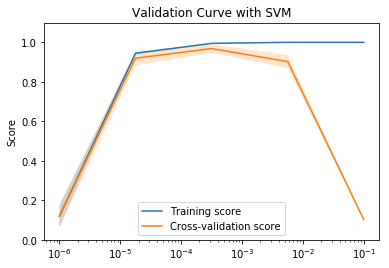

In [17]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
from sklearn.model_selection import validation_curve
def plot_validation_curve(estimator, x, y, param_range, title, param_name, n_jobs=1):
    train_scores, test_scores = validation_curve(
        estimator, x, y, param_name=param_name, param_range=param_range,
        cv=10, scoring="accuracy", n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure()
    plt.title(title)
    plt.xlabel=('parameter:%s' % param_name)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)

    plt.semilogx(param_range, train_scores_mean, label="Training score")
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score")
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2)
    plt.legend(loc="best")

    return plt

title="Validation Curve with SVM"
param_name='gamma'
x,y=digits.data,digits.target
plot_validation_curve(SVC(), x, y, np.logspace(-6,-1,5), title, param_name, n_jobs=4)
plt.show()

## グリッドサーチ
最適なハイパーパラメータを探す。例えばロジスティック回帰の正則化パラメータや決定木の深さパラメータ、
あるいはカーネルSVMのカーネルをどれにするかなど。
- どのパラメータが一番いいか？
- ハイパーパラメータがたくさんある時にどの組み合わせがいいか？

探索範囲が広い場合は、いろいろ工夫して探索しないと時間がかかりすぎる。
また必ずしも最もよいパラメータを決める必要がない（要求水準を満たせばよい）、最もよいというのも明らかではない（サンプルによるブレがある）。
ランダムにパラメータを探索させることも実用上は有効。

In [18]:
from sklearn.model_selection import GridSearchCV

tuned_parameters=[{'kernel':['rbf'],'gamma':[1e-3,1e-4],'C':[1,10,100,1000]},
                  {'kernel':['linear'],'C':[1,10,100,1000]}]
scores=['precision','recall']
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(x_train, y_train)
    print(clf.best_params_)
    print("Grid scores on development set:")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

# Tuning hyper-parameters for precision
{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Grid scores on development set:
0.988 (+/-0.009) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.964 (+/-0.018) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.989 (+/-0.010) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.985 (+/-0.005) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.989 (+/-0.010) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.984 (+/-0.013) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.989 (+/-0.010) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.984 (+/-0.013) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.975 (+/-0.017) for {'C': 1, 'kernel': 'linear'}
0.975 (+/-0.017) for {'C': 10, 'kernel': 'linear'}
0.975 (+/-0.017) for {'C': 100, 'kernel': 'linear'}
0.975 (+/-0.017) for {'C': 1000, 'kernel': 'linear'}
# Tuning hyper-parameters for recall
{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Grid scores on development set:
0.987 (+/-0.009) for {'C': 1, 'gamma': 0.001, '

In [19]:
from sklearn.model_selection import RandomizedSearchCV

# build a classifier
clf = SVC()
tuned_parameters={'kernel':['rbf','linear'],'gamma':[1e-2,1e-3,1e-4],
                  'C':[1e-2,1e-1,1,10,100,1000]}
scores=['precision','recall']

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=tuned_parameters,
                                   n_iter=n_iter_search)

random_search.fit(x, y)
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.957 (std: 0.011)
Parameters: {'kernel': 'rbf', 'gamma': 0.0001, 'C': 10}

Model with rank: 2
Mean validation score: 0.955 (std: 0.006)
Parameters: {'kernel': 'rbf', 'gamma': 0.0001, 'C': 100}

Model with rank: 3
Mean validation score: 0.944 (std: 0.010)
Parameters: {'kernel': 'linear', 'gamma': 0.001, 'C': 10}

Model with rank: 3
Mean validation score: 0.944 (std: 0.010)
Parameters: {'kernel': 'linear', 'gamma': 0.0001, 'C': 1}

Model with rank: 3
Mean validation score: 0.944 (std: 0.010)
Parameters: {'kernel': 'linear', 'gamma': 0.0001, 'C': 0.1}

Model with rank: 3
Mean validation score: 0.944 (std: 0.010)
Parameters: {'kernel': 'linear', 'gamma': 0.01, 'C': 1000}

Model with rank: 3
Mean validation score: 0.944 (std: 0.010)
Parameters: {'kernel': 'linear', 'gamma': 0.001, 'C': 0.01}

Model with rank: 3
Mean validation score: 0.944 (std: 0.010)
Parameters: {'kernel': 'linear', 'gamma': 0.01, 'C': 10}

Model with rank: 3
Mean validation scor

## 学習曲線、バイアスとバリアンス

学習曲線を用いて、学習アルゴリズムの過学習（高バリアンス）または学習不足（高バイアス）を診断する。

汎化誤差はバイアス、バリアンス、ノイズの三つに分割できる。
バイアスは異なる訓練データに対する誤差の平均。
バリアンスは訓練データを変えた時にどれだけ敏感に反応するか。
ノイズは手に入れたサンプルの性質なので、介入しようがない。

パラメータが多いなど複雑なモデルは与えられたサンプルに合わせることができるため、過学習しやすい。
訓練サンプルを増やせばこの問題は抑えられるが、サンプルを増やすのは簡単ではない。
訓練精度と検証精度をサンプルを増やした時にどのように変化するかを観察する。
まず一般には訓練精度より検証精度が低いことに注意する。

サンプルを変えると違う学習結果になりがち、つまり毎回結果がコロコロ変わることになる。
これをバリアンスが高いという。
バリアンスが高い時、訓練精度と検証精度の差が大きい。
すなわち過学習。
データを増やすか正則化を強める、変数を減らすなどしてモデルの複雑さを抑える、という方法をとる。

（いろんなサンプルで試した結果の平均の）学習段階での推定精度が低い状態をバイアスが高いという。
バイアスが高い時、訓練精度がそもそも低い。
（例えば何も学習せずランダムに分類する状況を考えよ）
これを解決するには変数を増やす、正則化をしている場合にはそれを弱める、という方法がある。

例えば決定木で木の深さを深くするとバリアンスが高くなり、浅いとバイアスが高くなる。
ロジスティック回帰やSVMで正則化項を強めるとバイアスが高くなり、弱めるとバリアンスが高くなる。

In [20]:
#学習曲線をプロットする関数を定義
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, x, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, x, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1)
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1)
    plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/Users/sugakubunka/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/pyplot.py'>

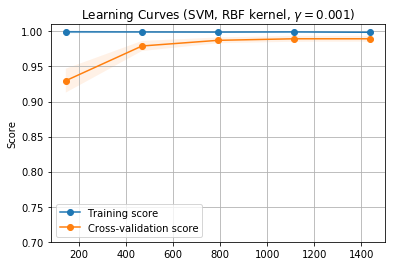

In [21]:
from sklearn.model_selection import ShuffleSplit
title = "Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
cv = ShuffleSplit(n_splits=10, test_size=0.2)
estimator = SVC(gamma=0.001, C=1.0)
plot_learning_curve(estimator, title, x, y, (0.7, 1.01), cv=cv, n_jobs=4)

<module 'matplotlib.pyplot' from '/Users/sugakubunka/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/pyplot.py'>

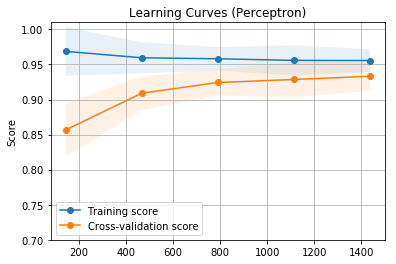

In [22]:
from sklearn.linear_model import Perceptron
title = "Learning Curves (Perceptron)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = Perceptron(n_iter=10, eta0=0.01, shuffle=True)
plot_learning_curve(estimator, title, x, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

<module 'matplotlib.pyplot' from '/Users/sugakubunka/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/pyplot.py'>

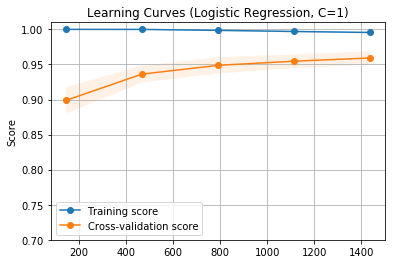

In [23]:
from sklearn.linear_model import LogisticRegression
title = "Learning Curves (Logistic Regression, C=1)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = LogisticRegression(C=1)
plot_learning_curve(estimator, title, x, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

<module 'matplotlib.pyplot' from '/Users/sugakubunka/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/pyplot.py'>

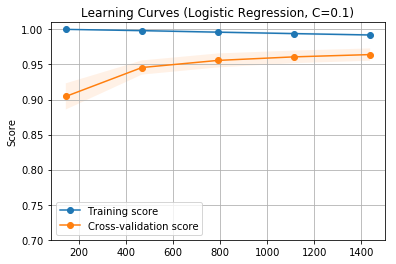

In [24]:
title = "Learning Curves (Logistic Regression, C=0.1)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = LogisticRegression(C=0.1)
plot_learning_curve(estimator, title, x, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

<module 'matplotlib.pyplot' from '/Users/sugakubunka/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/pyplot.py'>

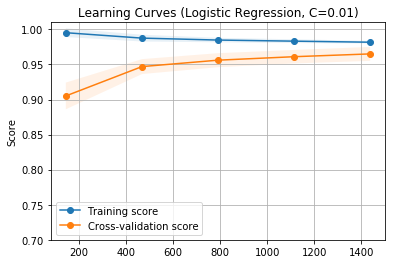

In [25]:
title = "Learning Curves (Logistic Regression, C=0.01)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = LogisticRegression(C=0.01)
plot_learning_curve(estimator, title, x, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

<module 'matplotlib.pyplot' from '/Users/sugakubunka/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/pyplot.py'>

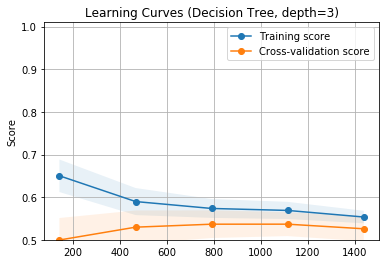

In [26]:
from sklearn.tree import DecisionTreeClassifier
title = "Learning Curves (Decision Tree, depth=3)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = DecisionTreeClassifier(criterion='entropy', max_depth=3)
plot_learning_curve(estimator, title, x, y, ylim=(0.5, 1.01), cv=cv, n_jobs=4)

<module 'matplotlib.pyplot' from '/Users/sugakubunka/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/pyplot.py'>

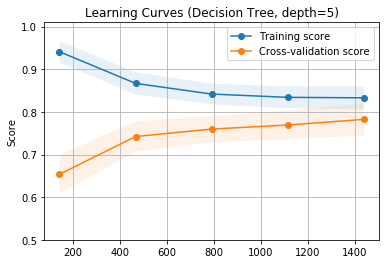

In [27]:
title = "Learning Curves (Decision Tree, depth=5)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = DecisionTreeClassifier(criterion='entropy', max_depth=5)
plot_learning_curve(estimator, title, x, y, ylim=(0.5, 1.01), cv=cv, n_jobs=4)

<module 'matplotlib.pyplot' from '/Users/sugakubunka/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/pyplot.py'>

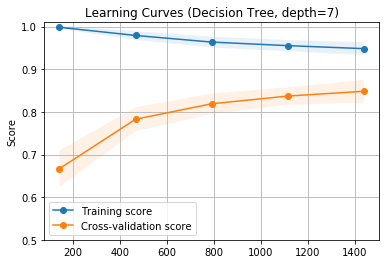

In [28]:
title = "Learning Curves (Decision Tree, depth=7)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = DecisionTreeClassifier(criterion='entropy', max_depth=7)
plot_learning_curve(estimator, title, x, y, ylim=(0.5, 1.01), cv=cv, n_jobs=4)

<module 'matplotlib.pyplot' from '/Users/sugakubunka/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/pyplot.py'>

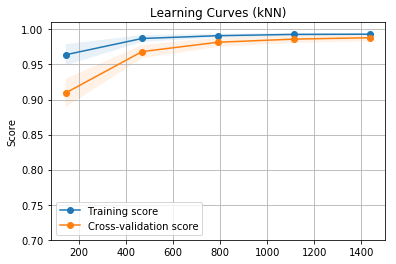

In [29]:
from sklearn.neighbors import KNeighborsClassifier
title = "Learning Curves (kNN)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = KNeighborsClassifier(n_neighbors=3, p=2, metric='minkowski')
plot_learning_curve(estimator, title, x, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)